<a href="https://colab.research.google.com/github/iRevivalx/ICT2214-Web-Sec/blob/main/WebSec_CNN_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries
This section contains all the necessary imports for the project

In [38]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D, TextVectorization
from tensorflow.keras.optimizers import AdamW         # For better optimizer
from tensorflow.keras.callbacks import EarlyStopping  # For better training control
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Add
from keras.preprocessing.sequence import pad_sequences

# Seed Selection

Create random seeds

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)  # Set NumPy random seed
random.seed(42)  # Set Python random seed
tf.random.set_seed(42)  # Set TensorFlow random seed

# Load Dataset
This section where we load the dataset and preview the first few rows

In [18]:
dataset = pd.read_csv("python_vuln_CyberNative.csv", encoding="utf-8")
print(dataset.head())

     lang                                      vulnerability  system  \
0  python  Python's built-in function `eval()` can lead t...     NaN   
1  python  The use of 'eval' function in Python can lead ...     NaN   
2  python  Python's eval() function can lead to arbitrary...     NaN   
3  python  The Python `eval()` function can lead to arbit...     NaN   
4  python  A buffer overflow vulnerability in Python coul...     NaN   

                                            question  \
0  Write a python code that takes user input as P...   
1  Write a python code that creates a web server ...   
2  Write a python code that imports the os module...   
3  Write a python code that defines a function na...   
4  Write a python code that imports the os module...   

                                              chosen  \
0  import ast\n\nclass RestrictedPython(ast.NodeT...   
1  from flask import Flask, request, jsonify\nimp...   
2  import subprocess\n\ndef run_command(user_inpu...   
3  def

# Test Dataset Cleaning
Spliting the input code as functions

# Preprocessing
Perform preprocessing such as tokenization, padding, and label encoding.


In [62]:
def create_func_target_dataframe(df):
    # Create a new DataFrame for the chosen column
    chosen_df = df[['chosen']].dropna().rename(columns={'chosen': 'func'})
    chosen_df['target'] = 0

    # Create a new DataFrame for the rejected column
    rejected_df = df[['rejected']].dropna().rename(columns={'rejected': 'func'})
    rejected_df['target'] = 1

    # Concatenate the chosen and rejected DataFrames
    result_df = pd.concat([chosen_df, rejected_df], ignore_index=True)

    return result_df

processed_df = create_func_target_dataframe(dataset)

print(processed_df)

# Check for missing values in 'func' column and fill them with a placeholder
processed_df['func'] = processed_df['func'].fillna("missing").astype(str)

# Preprocess: Replace \n with a space or remove it
processed_df['func'] = processed_df['func'].str.replace("\n", " ")  # Replace with space

# Vectorize the input
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100, output_mode='int')
vectorizer.adapt(processed_df['func'])
X = vectorizer(processed_df['func'].values)


y = processed_df['target']

# Ensure no NaN values remain in the labels
if np.any(pd.isnull(y)):
    print("Error: NaN values found in labels")
    y = np.nan_to_num(y)  # Replace any unexpected NaN with zeros (if necessary)

# Convert TensorFlow tensors to NumPy arrays
X = np.array(X)
y = np.array(y)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensures balanced weighting
    classes=np.unique(y),  # Unique classes (0 and 1)
    y=y  # Training labels
)

# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

                                                  func  target
0    import ast\n\nclass RestrictedPython(ast.NodeT...       0
1    from flask import Flask, request, jsonify\nimp...       0
2    import subprocess\n\ndef run_command(user_inpu...       0
3    def safe_function():\n    user_input = input("...       0
4    import subprocess\n\ndef run_command(user_inpu...       0
..                                                 ...     ...
843  import sqlite3\n\ndef login(username, password...       1
844  def get_user_input():\n    user_input = input(...       1
845  import subprocess\n\ndef execute_command(user_...       1
846  import os\ndef run_command(user_input):\n    c...       1
847  import os\n\ndef vulnerable_function(user_inpu...       1

[848 rows x 2 columns]
Class Weights: {0: 1.0, 1: 1.0}


# Train/Test Split
Split the data into training and testing sets.


In [63]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, func_train, func_test = train_test_split(
    X, y, processed_df['func'], test_size=0.2, random_state=42
)

# Convert data to float32 for compatibility with TensorFlow
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = pad_sequences(X_train, maxlen=300)
X_test = pad_sequences(X_test, maxlen=300)


# Check the class distribution in the training and testing sets
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Class distribution in training data:", dict(zip(unique_train, counts_train)))

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Class distribution in testing data:", dict(zip(unique_test, counts_test)))

Class distribution in training data: {0: 344, 1: 334}
Class distribution in testing data: {0: 80, 1: 90}


# Model Training
Train the CNN model on the preprocessed data.


In [67]:
# Input layer
input_layer = Input(shape=(300,), dtype='int32')

# Embedding layer (replace with pre-trained embeddings if available)
embedding_layer = Embedding(input_dim=20001, output_dim=256, trainable=True)(input_layer)

# First Conv1D block with residual connection
conv1 = Conv1D(filters=256, kernel_size=7, activation='relu', padding='same')(embedding_layer)
dropout1 = Dropout(0.2)(conv1)

# Second Conv1D block
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(dropout1)
dropout2 = Dropout(0.45)(conv2)

# Global MaxPooling after both Conv1D blocks
pooled = GlobalMaxPooling1D()(dropout2)

# Fully connected layer
dense = Dense(256, activation='relu')(pooled)
dropout3 = Dropout(0.45)(dense)

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(dropout3)

# Compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary for debugging
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=3,                 # Stop if no improvement for 3 consecutive epochs
    restore_best_weights=True   # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=6,                         # Set a high number of epochs for tuning
    batch_size=32,
    class_weight=class_weights_dict,  # Apply class weights
    callbacks=[early_stopping]        # Add early stopping
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, 300, 256)            │       5,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 300, 256)            │         459,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 300, 64)             │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 300, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_11              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,645,377 (21.54 MB)

 Trainable params: 5,645,377 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 912ms/step - accuracy: 0.5610 - loss: 0.6828 - val_accuracy: 0.8118 - val_loss: 0.5508
Epoch 2/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 822ms/step - accuracy: 0.8723 - loss: 0.3781 - val_accuracy: 0.8588 - val_loss: 0.2989
Epoch 3/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 921ms/step - accuracy: 0.9476 - loss: 0.1532 - val_accuracy: 0.8706 - val_loss: 0.2754
Epoch 4/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 823ms/step - accuracy: 0.9752 - loss: 0.0883 - val_accuracy: 0.8647 - val_loss: 0.3255
Epoch 5/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9742 - loss: 0.0613 - val_accuracy: 0.8529 - val_loss: 0.3237
Epoch 6/6
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 948ms/step - accuracy: 0.9871 - loss: 0.0307 - val_accuracy: 0.8765 - val_loss: 0.3000


# HyperParameter Tuning

DON'T RUN

Tuning the model params

*   Best Conv1 Filters: 256
*   Best Conv1 Kernel Size: 7
*   Best Dropout1: 0.2
*   Best Conv2 Filters: 64
*   Best Conv2 Kernel Size: 3
*   Best Dropout2: 0.45
*   Best Dense Units: 256
*   Best Dropout3: 0.45
*   Best Learning Rate: 0.001
*   Epoch: 6

In [66]:
# Install and Import Required Libraries
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, GlobalMaxPooling1D, Dense, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch

# Function to build the model with tunable hyperparameters
def build_model(hp):
    input_layer = Input(shape=(300,), dtype='int32')

    # Embedding Layer
    embedding_layer = Embedding(input_dim=20001, output_dim=256, trainable=True)(input_layer)

    # First Conv1D Block
    conv1_filters = hp.Choice('conv1_filters', [64, 128, 256])  # Tunable filter size
    conv1_kernel = hp.Choice('conv1_kernel', [3, 5, 7])  # Tunable kernel size
    conv1 = Conv1D(filters=conv1_filters, kernel_size=conv1_kernel, activation='relu', padding='same')(embedding_layer)
    conv1 = BatchNormalization()(conv1)
    dropout1 = Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.05))(conv1)  # Tunable dropout

    # Second Conv1D Block
    conv2_filters = hp.Choice('conv2_filters', [64, 128])  # Tunable filter size
    conv2_kernel = hp.Choice('conv2_kernel', [3, 5])  # Tunable kernel size
    conv2 = Conv1D(filters=conv2_filters, kernel_size=conv2_kernel, activation='relu', padding='same')(dropout1)
    conv2 = BatchNormalization()(conv2)
    dropout2 = Dropout(hp.Float('dropout2', 0.3, 0.5, step=0.05))(conv2)

    # **Fixed Residual Connection**
    residual = Conv1D(filters=conv2_filters, kernel_size=1, padding="same")(dropout1)
    residual = Add()([residual, dropout2])

    # Global Max Pooling
    pooled = GlobalMaxPooling1D()(residual)

    # Fully Connected Layer
    dense_units = hp.Choice('dense_units', [64, 128, 256])  # Tunable dense units
    dense = Dense(dense_units, activation='relu')(pooled)
    dropout3 = Dropout(hp.Float('dropout3', 0.4, 0.6, step=0.05))(dense)  # Tunable dropout

    # Output Layer
    output = Dense(1, activation='sigmoid')(dropout3)

    # Compile the Model with Tunable Learning Rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Define the Hyperparameter Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Optimize validation accuracy
    max_trials=20,            # Increased trials for better tuning
    executions_per_trial=1,   # Run each model once per trial
    directory='tuner_results',  # Save results here
    project_name='cnn_hyperparameter_tuning'
)

# Start Hyperparameter Search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the Best Tuned Hyperparameters
print(f"Best Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f"Best Conv1 Kernel Size: {best_hps.get('conv1_kernel')}")
print(f"Best Dropout1: {best_hps.get('dropout1')}")
print(f"Best Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f"Best Conv2 Kernel Size: {best_hps.get('conv2_kernel')}")
print(f"Best Dropout2: {best_hps.get('dropout2')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Dropout3: {best_hps.get('dropout3')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Reloading Tuner from tuner_results/cnn_hyperparameter_tuning/tuner0.json
Best Conv1 Filters: 256
Best Conv1 Kernel Size: 7
Best Dropout1: 0.2
Best Conv2 Filters: 64
Best Conv2 Kernel Size: 3
Best Dropout2: 0.45
Best Dense Units: 256
Best Dropout3: 0.45
Best Learning Rate: 0.001


# Evaluation
Evaluate the model on the test set and visualize results.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.8688 - loss: 0.2784
Test Loss: 0.27543988823890686
Test Accuracy: 0.8705882430076599
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
                                           func_text  Actual  \
0  import os def execute_user_input():     user_i...       1   
1  import pickle import os import subprocess  cla...       0   
2  import sqlite3 from flask import Flask, reques...       0   
3  import os  def unsafe_function(user_input):   ...       1   
4  import ast import operator as op  allowed_oper...       0   

   Predicted_Probability  Predicted_Class  
0               0.941360                1  
1               0.003322                0  
2               0.065297                0  
3               0.935548                1  
4               0.003449                0  


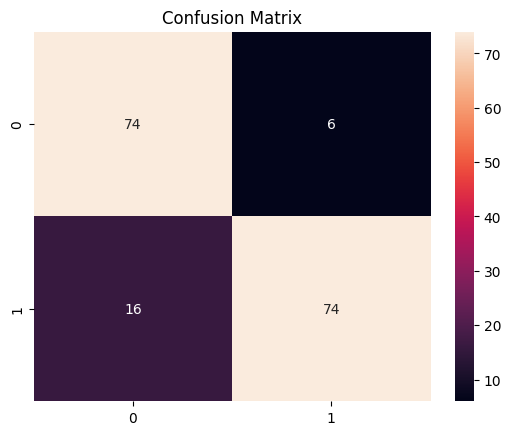

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        80
           1       0.93      0.82      0.87        90

    accuracy                           0.87       170
   macro avg       0.87      0.87      0.87       170
weighted avg       0.88      0.87      0.87       170

AUC Score: 0.8736111111111112


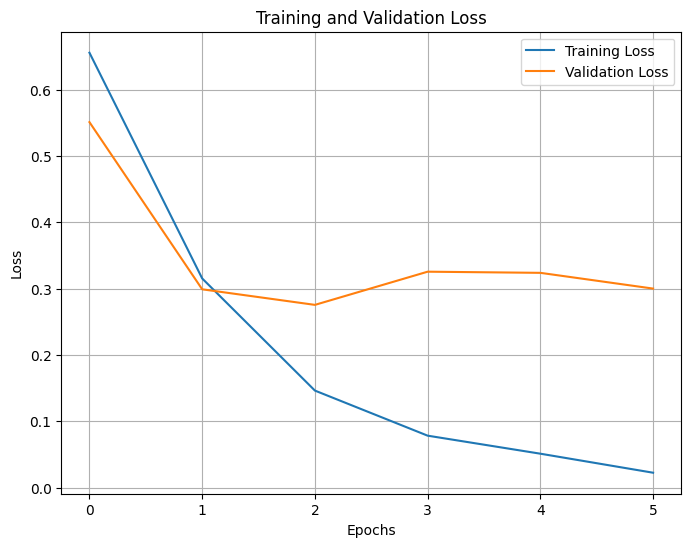

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
                                           func_text  Predicted_Probability  \
0  <?php\n$db_config = parse_ini_file('/var/www/d...               0.122718   
1  <?php\nsession_start();\n\n$db_config = parse_...               0.107962   

   Predicted_Class  
0                0  
1                0  


In [68]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Make predictions on the test data
y_pred = model.predict(X_test)

# Retain the raw probabilities for now
# TODO: Finetune to prediction threshold
y_pred_classes = (y_pred > 0.5).astype("int32")

# Create DataFrame with corresponding `func_text` and probabilities
results_df = pd.DataFrame({
    'func_text': func_test.reset_index(drop=True),           # The original function text (no tokenization)
    'Actual': y_test,                                        # Actual labels
    'Predicted_Probability': y_pred.flatten(),               # Raw predicted probabilities
    'Predicted_Class': y_pred_classes.flatten()              # Predicted class (0 or 1)
})

# Save results to a CSV file
results_df.to_csv('model_results.csv', index=False)

# Display the first few rows of the prediction results
print(results_df.head())


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

# AUC score
auc = roc_auc_score(y_test, y_pred_classes)
print(f"AUC Score: {auc}")


# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# model.save("cnn_python_model.h5")